# intro

The purpose of this notebook will be to try and craft an eloquent story of the Barents Sea. We will do this in three parts:

- 1: oceanography and gateways (velocity fields, gateway transports)
- 2: long term trends (heat content, PF location, SST and SSS trends, sea ice concentration trends
- 3: WMT (seasonal and long term breakdown and differences)

In [4]:
# import packages and functions, set up
import numpy as np
import sys
import matplotlib.pyplot as plt
# import pandas as pd
# import xarray as xr
# import h5py
# from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
import matplotlib.colors as mcolors

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [6]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [7]:
# define a fourth gate at the eastern edge (below commented in tracer coords)
# y_nzru = np.full((5),487)
# x_nzru = np.arange(525,530,1)

In [8]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

(400.0, 600.0)

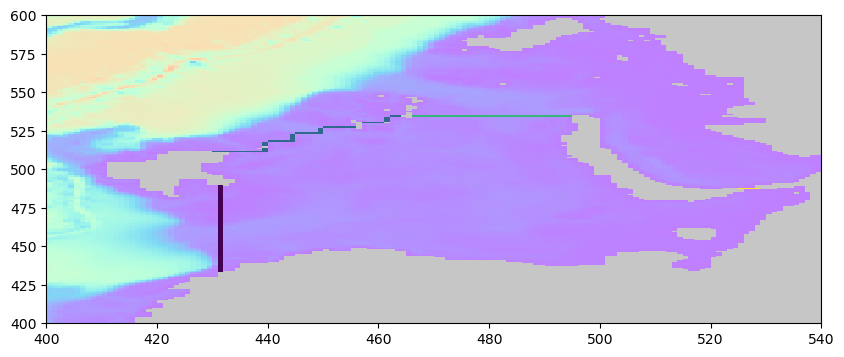

In [9]:
plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap='rainbow',alpha=0.5)
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# plt.plot(x_nzru,y_nzru)
plt.pcolormesh(get_aste_tracer(gates,nfx,nfy)[0])
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

plt.xlim(400,540)
plt.ylim(400,600)

In [10]:
# define the time stepping
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [11]:
# define a figure path
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Masking_discussion_april2/story/"

## Part 1: Oceanography and Gateways
Copy from velocity_fields.ipynb, google colab notebook for bathymetry, FullRundown_2years_3_26/gateway_transport.ipynb

In [12]:
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

In [13]:
tstart = 3
allyears[tstart:]
months_i = np.arange(0,12,1)
months_i

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [14]:
np.cumsum(mygrid['DRF'])[:5]

array([10., 20., 30., 40., 50.])

In [15]:
# define the path for UVEL and VVEL

dirtrsp = dirrun + "diags/TRSP/"

# read the files for velocity of upper 100m / bottom

# overlay on bathymetry
# make one set for DJFM and one set for JJAS
names_title = "Yearly"
months_i = np.arange(0,12,1)

all_UVEL = np.zeros((len(allyears[3:]),len(months_i),900,540))
all_VVEL = np.zeros((len(allyears[3:]),len(months_i),900,540))

all_UVEL_top100m = np.zeros((len(allyears[3:]),len(months_i),900,540))
all_VVEL_top100m = np.zeros((len(allyears[3:]),len(months_i),900,540))

iy = 0
# start reading from tstart (here 2006)
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

    #print(times)
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    for i in range(len(months_i)):
        read_tsstr = tsstr[months_i[i]]
        #print(read_tsstr)
    
        # read the fldList
        file_name = 'trsp_3d_set1'
        meta_trsp_3d_set1 = parsemeta(dirtrsp + file_name + "." + read_tsstr + ".meta")
        fldlist = np.array(meta_trsp_3d_set1["fldList"])
        varnames = np.array(["UVELMASS","VVELMASS"])
        recs = np.array([])
        #print(fldlist)
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        UVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[0])  # m/s
        UVELi = np.reshape(UVELi,(nz,ny,nx))
        VVELi,its,meta = rdmds(os.path.join(dirtrsp, file_name),int(read_tsstr),returnmeta=True,rec=recs[1])  # m/s
        VVELi = np.reshape(VVELi,(nz,ny,nx))

        # get the vector
        Uo,Vo = get_aste_vector_face1_3(UVELi,VVELi,nfx,nfy,False)
        Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

        # do depth averaging dependent on where you want
        Uo_AW = np.nanmean(Uo[10:],axis=0)
        Vo_AW = np.nanmean(Vo[10:],axis=0)
        Uo_ArW = np.nanmean(Uo[:5],axis=0)
        Vo_ArW = np.nanmean(Vo[:5],axis=0)

        # do averaging in depth and set in bigger array
        all_UVEL[iy,i] = Uo_AW
        all_VVEL[iy,i] = Vo_AW
        all_UVEL_top100m[iy,i] = Uo_ArW
        all_VVEL_top100m[iy,i] = Vo_ArW
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [12]:
# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears[tstart:]),ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    #print(march_tsstr)
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
    sample_SI = np.zeros((3,ny,nx))
    for i in range(3):
        read = int(tsstr[i])
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea
        sample_SI[i] = SIarea
    
    SIareas[iy] = np.nanmean(sample_SI,axis=0)  # time-averaging

    iy += 1



2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [13]:
SIareas[-3:].shape

(3, 1350, 270)

In [14]:
# get trace for sea ice
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

SI_early_tr = get_aste_tracer(np.nanmean(SIareas[:2], axis=0),nfx,nfy)[0]     # 2006–2008
SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[5:7], axis=0),nfx,nfy)[0]   # 2010-2011
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[-2:], axis=0),nfx,nfy)[0]      # 2015-2017

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_mid_tr_masked = np.where(landbuffer_tr, np.nan, SI_mid_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

In [15]:
# do time averaging of the subsurface layer and the upper ocean layer
all_UVEL_avg = np.nanmean(all_UVEL,axis=(0,1))
all_VVEL_avg = np.nanmean(all_VVEL,axis=(0,1))

all_UVEL_avg_top100m = np.nanmean(all_UVEL_top100m,axis=(0,1))
all_VVEL_avg_top100m = np.nanmean(all_VVEL_top100m,axis=(0,1))

In [16]:
# do the masking of these vectors with the basin - check first
test = get_aste_tracer(mymsk,nfx,nfy)[0]

all_UVEL_avg_msk = all_UVEL_avg * test
all_VVEL_avg_msk = all_VVEL_avg * test
all_UVEL_avg_top100m_msk = all_UVEL_avg_top100m * test
all_VVEL_avg_top100m_msk = all_VVEL_avg_top100m * test

In [33]:
# draw on the following the Lind Mask that we use

mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/mask_Lind.npz')
mymsk = mymsk['msk1']
msk1 = mymsk
lon = mygrid['XC']
lat = mygrid['YC']
mask = np.zeros_like(lat)
mask[(lat >= 76.25) & (lat <= 78.5) & (lon >= 27) & (lon <= 41)] = 1  # Masked region
mask[mask == 0 ] = np.nan


mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

In [2]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.colors import BoundaryNorm, ListedColormap


def truncate_colormap(cmap_name, minval=0.2, maxval=1.0, n=100):
    cmap = get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f'{cmap_name}_trunc',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

blues_trunc = truncate_colormap('Blues', 0.3, 1.0)
reds_trunc = truncate_colormap('Reds', 0.3, 1.0)

reds_trunc = ListedColormap(reds_trunc(np.linspace(0, 1, len(bounds)-1)))
blues_trunc = ListedColormap(blues_trunc(np.linspace(0, 1, len(bounds)-1)))

/tmp/ipykernel_1333779/4176984182.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)


NameError: name 'np' is not defined

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Setup colormap for bathymetry ---
colors = ['#7fcce0', '#3f479b', '#544596', '#534694', '#754898', '#9b4696', '#bd4896',
          '#d13b8d', '#e50f7c', '#e4034b', '#e3030e', '#e11108', '#e34b05', '#f18901',
          '#fcc903', '#f5e707', '#cfd600', '#a2c60e', '#7ebc20', '#6fb528', '#72b628', '#74bd6b']

bounds = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
          400, 500, 750, 1000, 1500, 2000, 4000, 6000]

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# --- Figure and subplots setup ---
fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

ax0 = fig.add_subplot(gs[0])  # Bathymetry
ax1 = fig.add_subplot(gs[1])  # Currents

# --- Bathymetry plot ---
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
land_data = get_aste_tracer(landmsk, nfx, nfy)[0]

pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen', linewidths=1.5, linestyles='--',label= "'06-'07 sea ice")
# ax0.contour(SI_mid_tr_masked, levels=[0.15], colors='purple', linewidths=1.5, linestyles='--',label= "'10-'11 sea ice")
ax0.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--',label= "'16-'17 sea ice")

# Bathymetry colorbar (vertical)
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8,
                   pad=0.02, boundaries=bounds)

ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry", fontsize=12)

# also plot the gates on this one
black_cmap = ListedColormap(['black'])

# Plot with the colormap
pc = ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)

legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5, label="15% SI, JFM, '06–'07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5, label="15% SI, JFM, '16–'17"),
]

ax0.legend(handles=legend_elements,
           loc='lower left',
           bbox_to_anchor=(.6, -.2),
           fontsize=10,
           frameon=True,
           title='Contours')

# --- Currents streamplot on right subplot ---
ny1, nx1 = all_UVEL_avg_msk.shape
x = np.arange(nx1)
y = np.arange(ny1)

# Contour lines of depth
contour_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
ax1.set_facecolor("white")  # Very light gray
ax1.contour(contour_data, levels=[1, 100, 200, 300, 400, 500, 600],
            colors='grey', linewidths=0.8, alpha=0.7)
ax1.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=2)


# Compute speeds for color
speed_full = np.sqrt(all_UVEL_avg_msk**2 + all_VVEL_avg_msk**2)
speed_top = np.sqrt(all_UVEL_avg_top100m_msk**2 + all_VVEL_avg_top100m_msk**2)

# Streamplot: full water column (red)

density=5
strm1 = ax1.streamplot(
    x, y,
    all_UVEL_avg_msk,
    all_VVEL_avg_msk,
    color=speed_full,
    cmap=reds_trunc,
    norm=plt.Normalize(vmin=0, vmax=np.nanpercentile(speed_full, 95)),
    density=(density),
    linewidth=2,
    arrowsize=2,
    zorder=3
)

# Streamplot: top 100m (blue)
strm2 = ax1.streamplot(
    x, y,
    all_UVEL_avg_top100m_msk,
    all_VVEL_avg_top100m_msk,
    color=speed_top,
    cmap=blues_trunc,
    norm=plt.Normalize(vmin=0, vmax=np.nanpercentile(speed_top, 95)),
    density=(density),
    linewidth=2,
    arrowsize=2,
    zorder=4
)

ax1.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6,zorder=10)
tmp = sample_cross.copy()
tmp[~np.isnan(tmp)] = 1
ax1.pcolormesh(get_aste_tracer(tmp,nfx,nfy)[0] *test,cmap="Greys",zorder=1,alpha=.3,vmin=-1,vmax=1.2)

# Adjust space at the bottom for global colorbars
plt.subplots_adjust(bottom=0.2)

# Full-width colorbar for 100m+ currents (Red)
cb1_ax = fig.add_axes([0.55, -0.05, 0.35, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(strm1.lines, cax=cb1_ax, orientation='horizontal')
cb1.set_label("Speed (m/s) — 100m+")

# Full-width colorbar for top 100m currents (Blue)
cb2_ax = fig.add_axes([0.55, 0.11, 0.35, 0.02])
cb2 = fig.colorbar(strm2.lines, cax=cb2_ax, orientation='horizontal')
cb2.set_label("Speed (m/s) — Top 50m ")

# Styling for right plot
ax1.set_xlim(400, 540)
ax1.set_ylim(430, 560)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Currents with Depth Contours", fontsize=12)

plt.tight_layout()

# plt.savefig("story/currents_lindmsk_withcross.png",dpi=300)


NameError: name 'mcolors' is not defined

In [52]:
# Define seasonal month indices (based on months_i = 0–11)
season_names = ['JFM', 'AMJ', 'ASO', 'OND']
season_months = [
    [0, 1, 2],   # Jan–Feb–Mar
    [3, 4, 5],   # Apr–May–Jun
    [7, 8, 9],   # Aug–Sep–Oct
    [9, 10, 11]  # Oct–Nov–Dec (note: includes Oct again, rename if needed)
]

seasonal_UVEL = {}
seasonal_VVEL = {}
seasonal_UVEL_top = {}
seasonal_VVEL_top = {}

for name, months in zip(season_names, season_months):
    seasonal_UVEL[name] = np.nanmean(all_UVEL[:, months, :, :], axis=(0, 1))
    seasonal_VVEL[name] = np.nanmean(all_VVEL[:, months, :, :], axis=(0, 1))
    seasonal_UVEL_top[name] = np.nanmean(all_UVEL_top100m[:, months, :, :], axis=(0, 1))
    seasonal_VVEL_top[name] = np.nanmean(all_VVEL_top100m[:, months, :, :], axis=(0, 1))

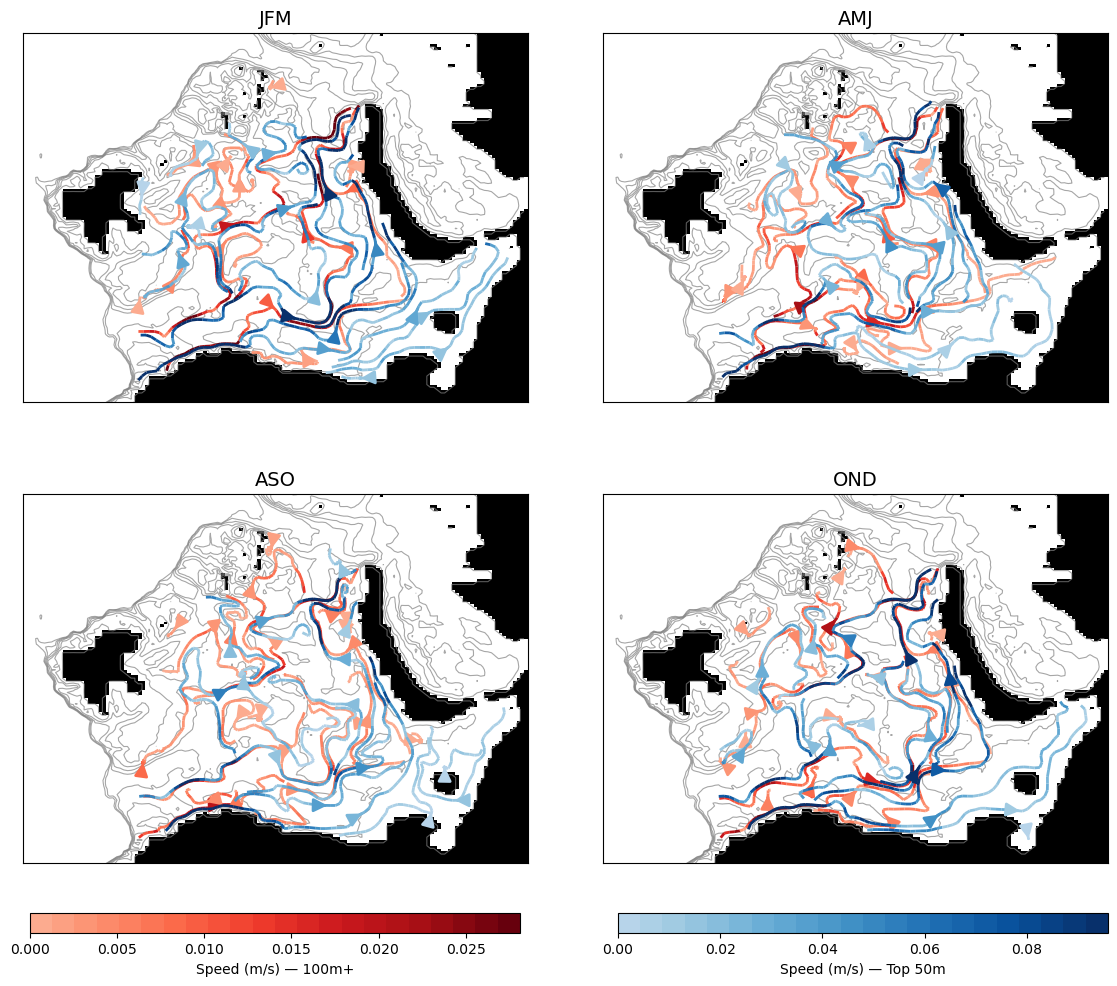

In [53]:
# Create the figure and 2x2 axes grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=False)
axs = axs.flatten()

# Common grid, land mask, depth contour data
ny1, nx1 = seasonal_UVEL['JFM'].shape
x = np.arange(nx1)
y = np.arange(ny1)
contour_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
land_data = get_aste_tracer(landmsk, nfx, nfy)[0]

# Normalize speeds for all seasons to the same scale
all_speeds_full = [np.sqrt(seasonal_UVEL[sn]**2 + seasonal_VVEL[sn]**2) for sn in season_names]
all_speeds_top = [np.sqrt(seasonal_UVEL_top[sn]**2 + seasonal_VVEL_top[sn]**2) for sn in season_names]

vmax_full = np.nanpercentile(np.concatenate([s.ravel() for s in all_speeds_full]), 95)
vmax_top = np.nanpercentile(np.concatenate([s.ravel() for s in all_speeds_top]), 95)

# Plot each season
for i, season in enumerate(season_names):
    ax = axs[i]
    ax.set_facecolor("white")

    # Plot land
    ax.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=2)

    # Depth contours
    ax.contour(contour_data, levels=[1, 100, 200, 300, 400, 500, 600],
               colors='grey', linewidths=0.8, alpha=0.7)

    # Get seasonal velocities
    u_full = seasonal_UVEL[season] * test
    v_full = seasonal_VVEL[season] * test
    u_top = seasonal_UVEL_top[season] * test
    v_top = seasonal_VVEL_top[season] * test

    # Compute speeds
    speed_full = np.sqrt(u_full**2 + v_full**2)
    speed_top = np.sqrt(u_top**2 + v_top**2)

    # Plot streamlines
    density = 12
    strm1 = ax.streamplot(
        x, y, u_full, v_full,
        color=speed_full, cmap=reds_trunc,
        norm=plt.Normalize(vmin=0, vmax=vmax_full),
        density=density, linewidth=2, arrowsize=2, zorder=3
    )

    strm2 = ax.streamplot(
        x, y, u_top, v_top,
        color=speed_top, cmap=blues_trunc,
        norm=plt.Normalize(vmin=0, vmax=vmax_top),
        density=density, linewidth=2, arrowsize=2, zorder=4
    )

    ax.set_xlim(400, 540)
    ax.set_ylim(430, 560)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(season, fontsize=14)

# Colorbars below the entire figure
plt.subplots_adjust(bottom=0.12, top=0.95, wspace=0.15, hspace=0.25)

# Full-width colorbar for 100m+ currents (Red)
cb1_ax = fig.add_axes([0.13, 0.05, 0.35, 0.02])  # [left, bottom, width, height]
cb1 = fig.colorbar(strm1.lines, cax=cb1_ax, orientation='horizontal')
cb1.set_label("Speed (m/s) — 100m+")

# Full-width colorbar for top 100m currents (Blue)
cb2_ax = fig.add_axes([0.55, 0.05, 0.35, 0.02])
cb2 = fig.colorbar(strm2.lines, cax=cb2_ax, orientation='horizontal')
cb2.set_label("Speed (m/s) — Top 50m")

# Save the figure
plt.savefig("seasonal_barents_currents_2x2_lindmsk.png", dpi=300, bbox_inches='tight')
plt.show()

# plot the average gateway transport - T profile, ADV, S profile for each of the gates

In [54]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

In [22]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        #print(y_idx)
        for depth in range(nz):
            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx]
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx]

    iy += 1  # Move to the next year


Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [23]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [24]:
choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [25]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * ADVx_TH_all[:, depth, y_idx, x_idx]
            advy_seasonal = myparms["rcp"] * ADVy_TH_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, :, depth, :] = adv_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [26]:
# do averaging by years and months

theta_avg = {gate: np.nanmean(theta_timeseries[gate], axis=(0, 1)) for gate in gate_labels}
salt_avg  = {gate: np.nanmean(salt_timeseries[gate], axis=(0, 1))  for gate in gate_labels}
heat_avg  = {gate: np.nanmean(heat_transport_timeseries[gate], axis=(0, 1)) for gate in gate_labels}


In [27]:
x_labels = {
    "BSO": "km from Norway to SP (increasing toward SP)",
    "SFJ": "km from SFJ to SP (increasing toward SP)",
    "FJNZ": "km from NZ to SFJ (increasing toward SFJ)",
    "NZRU": "km from RU to NZ (increasing toward NZ)"
}

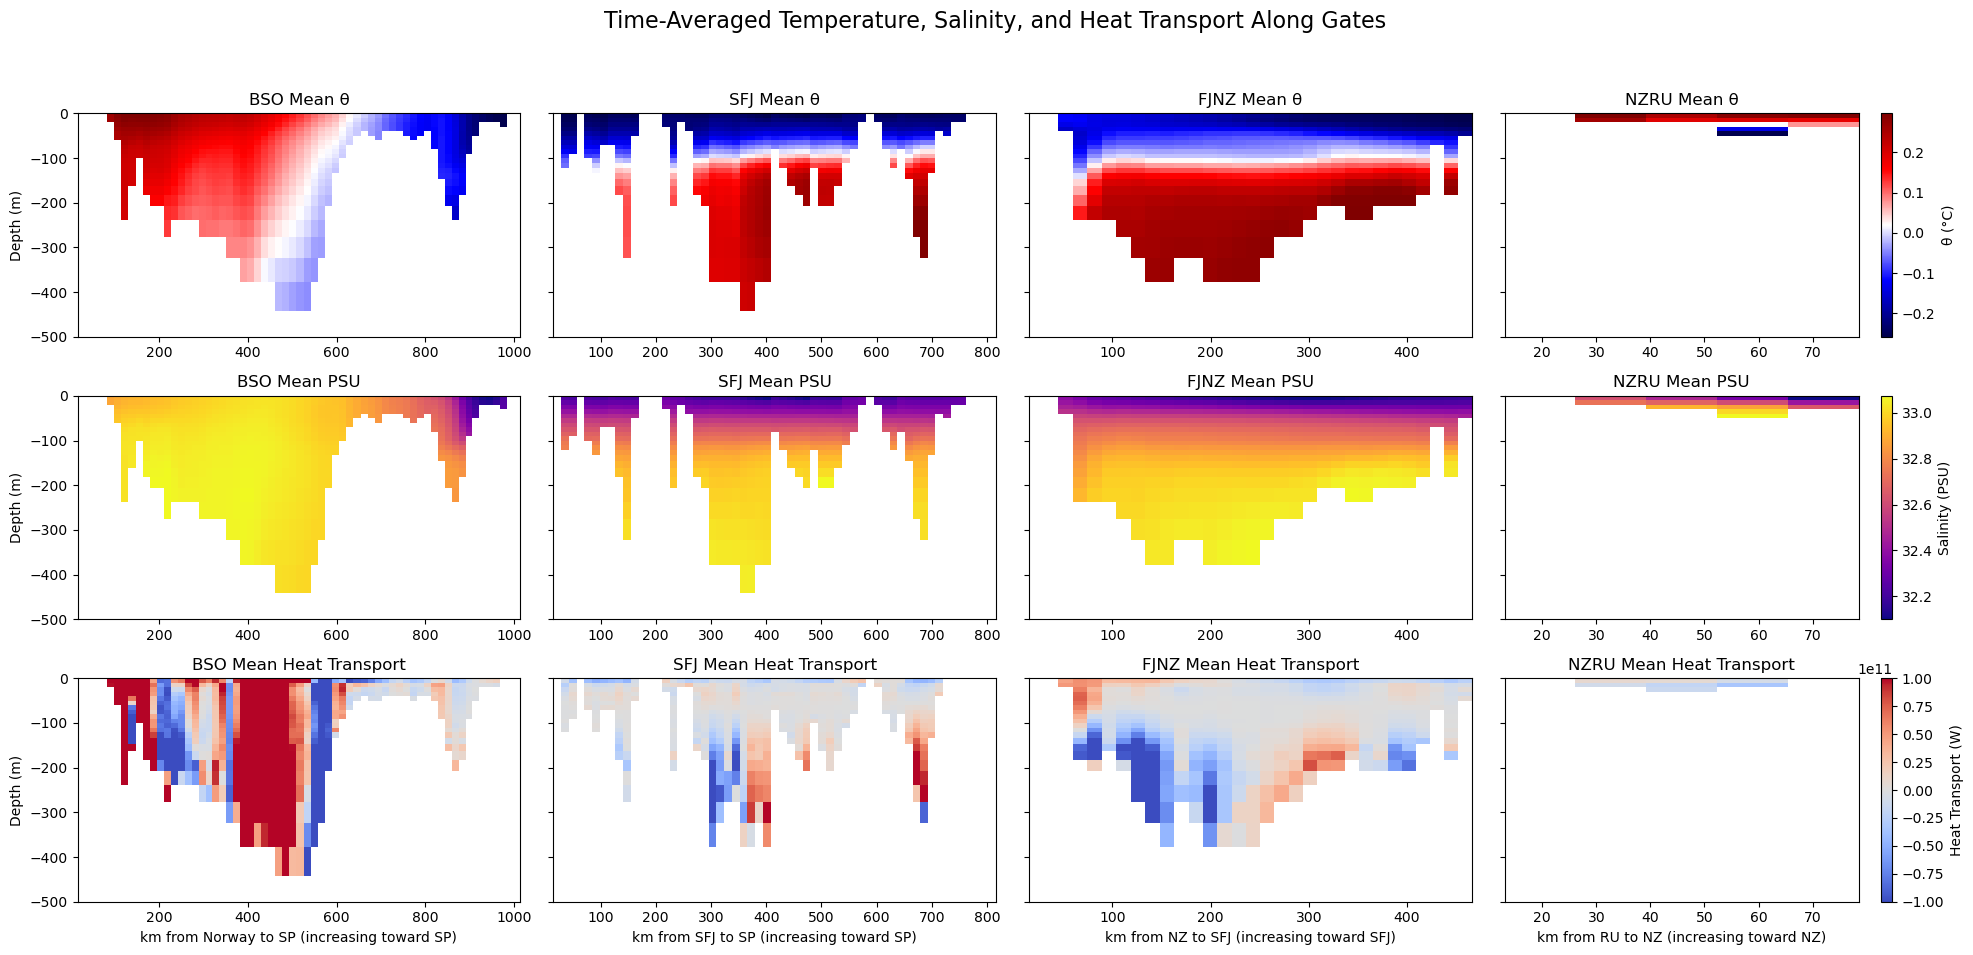

In [66]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharey=True)

x_vals = {gate: gate_distances[gate] for gate in gate_labels}
y_vals = np.cumsum(-mygrid['DRF'])  # vertical cell centers or edges depending on context

for col, gate in enumerate(gate_labels):
    X_center = x_vals[gate]
    Y_center = y_vals

    # Construct cell edges for pcolormesh
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])
    y_edges = np.concatenate([[0], Y_center])

    # Mask 0s
    theta = theta_avg[gate]
    theta[theta == 0] = np.nan
    salt = salt_avg[gate]
    salt[salt == 0] = np.nan
    heat = heat_avg[gate]
    heat[heat == 0] = np.nan

    # θ
    im1 = axes[0, col].pcolormesh(x_edges, y_edges, theta, cmap='seismic', shading='auto')
    axes[0, col].set_title(f"{gate} Mean θ")
    axes[0, col].set_ylim(-500, 0)
    if col == 0:
        axes[0, col].set_ylabel("Depth (m)")
    if col == 3:
        fig.colorbar(im1, ax=axes[0, col], orientation='vertical', label='θ (°C)')

    # S
    im2 = axes[1, col].pcolormesh(x_edges, y_edges, salt, cmap='plasma', shading='auto')
    axes[1, col].set_title(f"{gate} Mean PSU")
    axes[1, col].set_ylim(-500, 0)
    if col == 0:
        axes[1, col].set_ylabel("Depth (m)")
    if col == 3:
        fig.colorbar(im2, ax=axes[1, col], orientation='vertical', label='Salinity (PSU)')

    # Q
    im3 = axes[2, col].pcolormesh(x_edges, y_edges, heat, cmap='coolwarm', vmin=-1e11, vmax=1e11, shading='auto')
    axes[2, col].set_title(f"{gate} Mean Heat Transport")
    axes[2, col].set_ylim(-500, 0)
    if col == 0:
        axes[2, col].set_ylabel("Depth (m)")
    axes[2, col].set_xlabel(x_labels[gate])
    if col == 3:
        fig.colorbar(im3, ax=axes[2, col], orientation='vertical', label='Heat Transport (W)')

fig.suptitle("Time-Averaged Temperature, Salinity, and Heat Transport Along Gates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("story/gates_fluidcolorbar.png", dpi=300)
# plt.close()


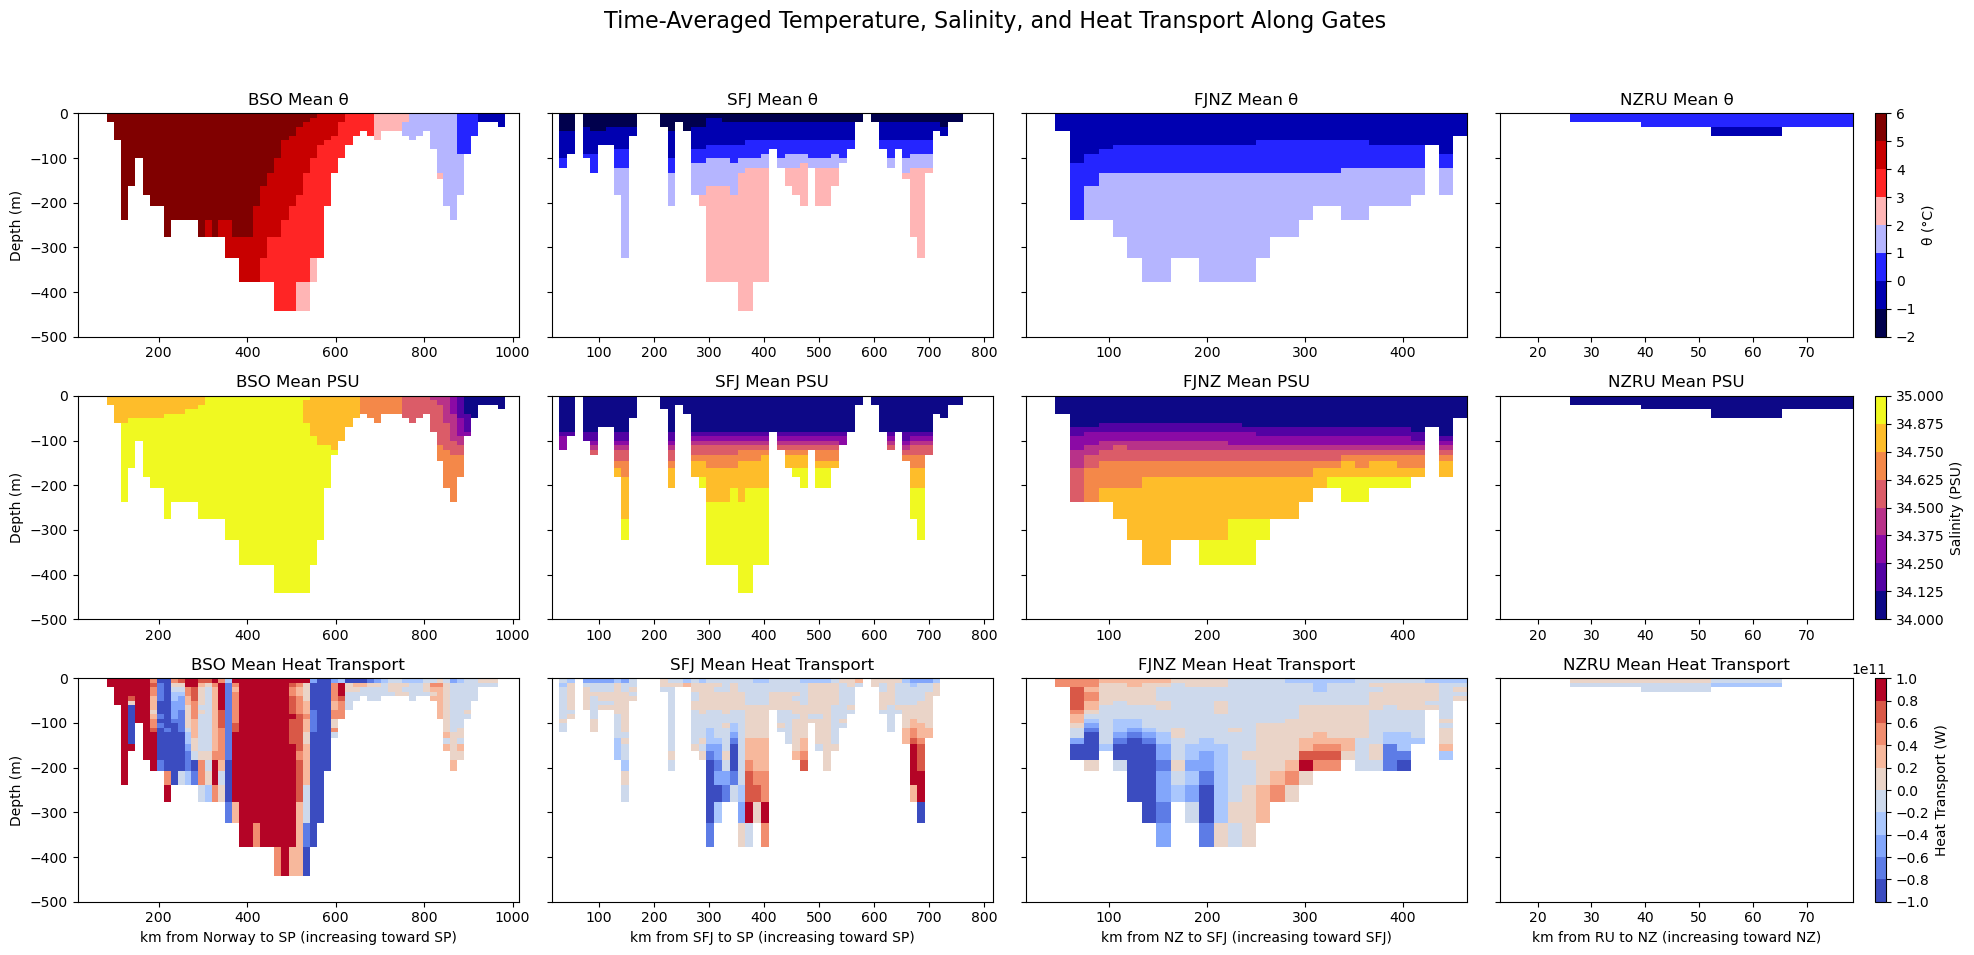

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create segmented colormaps
def create_segmented_cmap(cmap_name, bounds):
    base = plt.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, len(bounds) - 1))
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bounds, ncolors=len(bounds) - 1)
    return cmap, norm

# Define color bounds (tweak based on your data range)
theta_bounds = np.linspace(-2, 6, 9)       # For θ in °C
salt_bounds = np.linspace(34, 35, 9)       # For salinity in PSU
heat_bounds = np.linspace(-1e11, 1e11, 11) # For heat transport in W

theta_cmap, theta_norm = create_segmented_cmap('seismic', theta_bounds)
salt_cmap, salt_norm   = create_segmented_cmap('plasma', salt_bounds)
heat_cmap, heat_norm   = create_segmented_cmap('coolwarm', heat_bounds)

fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharey=True)

x_vals = {gate: gate_distances[gate] for gate in gate_labels}
y_vals = np.cumsum(-mygrid['DRF'])  # depth should be negative

for col, gate in enumerate(gate_labels):
    X_center = x_vals[gate]
    Y_center = y_vals

    # Construct cell edges
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])
    y_edges = np.concatenate([[0], Y_center])

    # Mask 0s
    theta = theta_avg[gate]
    theta[theta == 0] = np.nan
    salt = salt_avg[gate]
    salt[salt == 0] = np.nan
    heat = heat_avg[gate]
    heat[heat == 0] = np.nan

    # θ
    im1 = axes[0, col].pcolormesh(x_edges, y_edges, theta, cmap=theta_cmap, norm=theta_norm, shading='auto')
    axes[0, col].set_title(f"{gate} Mean θ")
    axes[0, col].set_ylim(-500, 0)
    if col == 0:
        axes[0, col].set_ylabel("Depth (m)")
    if col == 3:
        fig.colorbar(im1, ax=axes[0, col], orientation='vertical', label='θ (°C)', ticks=theta_bounds)

    # S
    im2 = axes[1, col].pcolormesh(x_edges, y_edges, salt, cmap=salt_cmap, norm=salt_norm, shading='auto')
    axes[1, col].set_title(f"{gate} Mean PSU")
    axes[1, col].set_ylim(-500, 0)
    if col == 0:
        axes[1, col].set_ylabel("Depth (m)")
    if col == 3:
        fig.colorbar(im2, ax=axes[1, col], orientation='vertical', label='Salinity (PSU)', ticks=salt_bounds)

    # Q
    im3 = axes[2, col].pcolormesh(x_edges, y_edges, heat, cmap=heat_cmap, norm=heat_norm, shading='auto')
    axes[2, col].set_title(f"{gate} Mean Heat Transport")
    axes[2, col].set_ylim(-500, 0)
    if col == 0:
        axes[2, col].set_ylabel("Depth (m)")
    axes[2, col].set_xlabel(x_labels[gate])
    if col == 3:
        fig.colorbar(im3, ax=axes[2, col], orientation='vertical', label='Heat Transport (W)', ticks=heat_bounds)

fig.suptitle("Time-Averaged Temperature, Salinity, and Heat Transport Along Gates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("story/gate_mean_TSQ_segmentedcolorbar.png", dpi=300)
# plt.close()


# plot T and S transects as averages for the sections

In [ ]:
# we said lon = 25,30,35,40

# do as three averages - first four years, mid four years, final four years

# define a sample cross section for this region

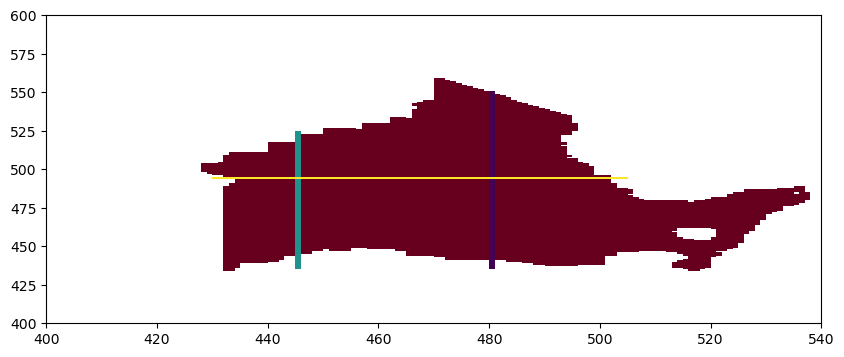

In [102]:

y_sample = np.arange(435,551,1)
x_sample = np.full(y_sample.shape,480)
y_sample1 = np.arange(435,525,1)
x_sample1 = np.full(y_sample1.shape,445)

x_cross = np.arange(430,505,1)
y_cross = np.full(x_cross.shape,494)


# plt.plot(x_sample,y_sample)
# plt.plot(x_sample1,y_sample1)
# plt.plot(x_cross,y_cross)

sample_cross = np.full((900,540),np.nan)
sample_cross[y_sample,x_sample]= 1
sample_cross[y_sample1,x_sample1]= 2
sample_cross[y_cross,x_cross]= 3
sample_cross = aste_tracer2compact(sample_cross,nfx,nfy)[0]

plt.pcolormesh(test,cmap="RdBu")
plt.pcolormesh(get_aste_tracer(sample_cross,nfx,nfy)[0])
plt.xlim(400,540)
plt.ylim(400,600)

y_left,x_left = np.where(sample_cross == 1)[0], np.where(sample_cross == 1)[1]  # 
y_right,x_right = np.where(sample_cross == 2)[0], np.where(sample_cross == 2)[1]
y_lateral,x_lateral = np.where(sample_cross == 3)[0], np.where(sample_cross == 3)[1]

In [125]:
y_lateral

array([485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497,
       498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
       511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523,
       524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536,
       537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549,
       550, 551, 552, 553, 554, 555, 556, 557, 558, 559])

In [108]:
# Define dimensions
num_years = len(allyears[tstart:])  # Number of years
gate_labels = ["NS1", "NS2", "EW"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(sample_cross == label) for gate, label in zip(gate_labels, [1, 2, 3])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears[tstart:]:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        #print(y_idx)
        for depth in range(nz):
            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx]
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx]

    iy += 1  # Move to the next year


Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [110]:
choose_UV_NS1 = line_orientation(y_left,x_left)
choose_UV_NS2 = line_orientation(y_right,x_right)
choose_UV_EW = line_orientation(y_lateral,x_lateral)

In [111]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_left, y_left, choose_UV_NS1), 
                                                                (x_right, y_right, choose_UV_NS2), 
                                                                (x_lateral, y_lateral, choose_UV_EW)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [118]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define symmetric bounds for segmented levels (e.g. anomaly °C)
theta_bounds = np.linspace(-4, 4,  nine_steps := 19)  # 9 segments from -4 to 4
base_cmap = plt.get_cmap('RdBu_r')  # reversed so blue = negative, red = positive
colors = base_cmap(np.linspace(0, 1, nine_steps - 1))

# Create segmented colormap and norm
theta_cmap = ListedColormap(colors)
theta_norm = BoundaryNorm(theta_bounds, ncolors=theta_cmap.N)


In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Year blocks: 2006–2009, 2010–2013, 2014–2017
year_blocks = [(0, 4), (4, 8), (8, 12)]
block_labels = ["2006–2009", "2010–2013", "2014–2017"]

# Depth and gate distances
depth_edges = np.concatenate([[0], np.cumsum(-mygrid['DRF'])])
depth = -np.cumsum(mygrid['DRF'])  # for center values

# Loop over gates to generate one figure per gate
for gate in gate_labels:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f"{gate} Cross-Section of θ by 4-Year Period", fontsize=16)

    X_center = gate_distances[gate]
    ngate = X_center.size
    x_edges = np.concatenate([X_center, [X_center[-1] + (X_center[-1] - X_center[-2])]])

    for i, ((start, end), label) in enumerate(zip(year_blocks, block_labels)):
        ax = axes[i]
        theta_data = theta_timeseries[gate]  # shape: (years, 12, nz, length)
        block = theta_data[start:end, :, :, :]  # shape: (4, 12, nz, length)
        theta_avg = np.nanmean(block, axis=(0, 1))  # avg over years and months → shape (nz, length)
        theta_avg[theta_avg == 0] = np.nan  # mask out zeros

        # pcolormesh expects shape (ny, nx) so transpose
        im = ax.pcolormesh(x_edges, depth_edges, theta_avg, cmap=theta_cmap, norm=theta_norm, shading='auto')
        ax.set_title(label)
        ax.set_ylim(-500, 0)
        if gate == "EW":
            ax.set_xlabel("Distance (km) Sp. to NZ")
        elif gate == "NS1":
            ax.set_xlabel("Distance (km) Ru. to AO")
        elif gate == "NS2":
            ax.set_xlabel("Distance (km) No. to AO")
        if i == 0:
            ax.set_ylabel("Depth (m)")
        fig.colorbar(im, ax=ax, orientation='vertical', label='θ (°C)', ticks=theta_bounds)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"story/theta_crosssection_{gate}.png", dpi=300)
    plt.close()